# Hourly Forecasting Carbon Intensity using MLP #

## Importing modules ##

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time
import sys, os

# Add path to power_monitor
sys.path.append(os.path.abspath('../LibreHardwareMonitor-net472'))
from power_monitor import PowerMonitor

# Dictionary to store execution times for each code block
execution_times = {}
power_stats = {}

## Processing data for hourly carbon intensity ##

In [19]:
with PowerMonitor("Hourly_MLP_Forecasting.csv") as pm:
    start_time = time.time()
    # Load the dataset
    df = pd.read_csv('../data/df_fuel_ckan.csv')
    df['DATETIME'] = pd.to_datetime(df['DATETIME'])
    df.set_index('DATETIME', inplace=True)

    # Resample to hourly frequency and take the mean
    df_hourly = df['CARBON_INTENSITY'].resample('h').mean().reset_index()

    # Interpolate any missing hourly segments
    df_hourly['CARBON_INTENSITY'] = df_hourly['CARBON_INTENSITY'].interpolate(method='linear')

    # Check data
    print("Hourly Data Head:")
    print(df_hourly.head())
    print("\nShape:", df_hourly.shape)
    execution_times['Data Processing'] = time.time() - start_time
power_stats['Data Processing'] = pm.stats()


Hourly Data Head:
             DATETIME  CARBON_INTENSITY
0 2009-01-01 00:00:00             525.0
1 2009-01-01 01:00:00             527.0
2 2009-01-01 02:00:00             528.5
3 2009-01-01 03:00:00             531.0
4 2009-01-01 04:00:00             534.5

Shape: (148835, 2)


## Feature Engineering for Hourly Data ##

In [20]:
with PowerMonitor("Hourly_MLP_Forecasting.csv") as pm:
    start_time = time.time()
    def create_hourly_features(data):
        df = data.copy()
        
        # Time-based features
        df['hour'] = df['DATETIME'].dt.hour
        df['day_of_week'] = df['DATETIME'].dt.dayofweek
        df['month'] = df['DATETIME'].dt.month
        df['day_of_year'] = df['DATETIME'].dt.dayofyear
        df['year'] = df['DATETIME'].dt.year
        
        # Lag features (past values)
        # Lag 1 hour, 24 hours (1 day), 168 hours (1 week)
        for l in [1, 24, 168]:
            df[f'lag_{l}'] = df['CARBON_INTENSITY'].shift(l)
            
        # Rolling mean features
        # 24-hour rolling mean
        df['rolling_mean_24'] = df['CARBON_INTENSITY'].shift(1).rolling(window=24).mean()
        # 1-week rolling mean
        df['rolling_mean_168'] = df['CARBON_INTENSITY'].shift(1).rolling(window=168).mean()
        
        return df.dropna()

    df_features = create_hourly_features(df_hourly)
    print("Features Head:")
    print(df_features.head())
    execution_times['Feature Engineering'] = time.time() - start_time
power_stats['Feature Engineering'] = pm.stats()


Features Head:
               DATETIME  CARBON_INTENSITY  hour  day_of_week  month  \
168 2009-01-08 00:00:00             600.0     0            3      1   
169 2009-01-08 01:00:00             598.0     1            3      1   
170 2009-01-08 02:00:00             598.5     2            3      1   
171 2009-01-08 03:00:00             600.0     3            3      1   
172 2009-01-08 04:00:00             601.0     4            3      1   

     day_of_year  year  lag_1  lag_24  lag_168  rolling_mean_24  \
168            8  2009  605.0   604.0    525.0       599.750000   
169            8  2009  600.0   605.5    527.0       599.583333   
170            8  2009  598.0   606.5    528.5       599.270833   
171            8  2009  598.5   608.0    531.0       598.937500   
172            8  2009  600.0   609.5    534.5       598.604167   

     rolling_mean_168  
168        576.255952  
169        576.702381  
170        577.125000  
171        577.541667  
172        577.952381  


## Train/Validation/Test Split ##

In [21]:
with PowerMonitor("Hourly_MLP_Forecasting.csv") as pm:
    start_time = time.time()
    train_data = df_features[df_features['year'] < 2024]
    val_data = df_features[df_features['year'] == 2024]
    test_data = df_features[df_features['year'] == 2025]

    X_train = train_data.drop(['DATETIME', 'CARBON_INTENSITY', 'year'], axis=1)
    y_train = train_data['CARBON_INTENSITY']

    X_val = val_data.drop(['DATETIME', 'CARBON_INTENSITY', 'year'], axis=1)
    y_val = val_data['CARBON_INTENSITY']

    X_test = test_data.drop(['DATETIME', 'CARBON_INTENSITY', 'year'], axis=1)
    y_test = test_data['CARBON_INTENSITY']

    print(f"Train size: {len(X_train)}")
    print(f"Validation size: {len(X_val)}")
    print(f"Test size: {len(X_test)}")
    execution_times['Data Splitting'] = time.time() - start_time
power_stats['Data Splitting'] = pm.stats()


Train size: 131304
Validation size: 8784
Test size: 8579


## Data Scaling ##

In [22]:
with PowerMonitor("Hourly_MLP_Forecasting.csv") as pm:
    start_time = time.time()
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_train_scaled = scaler_X.fit_transform(X_train)
    X_val_scaled = scaler_X.transform(X_val)
    X_test_scaled = scaler_X.transform(X_test)

    # Reshape y to (n_samples, 1) for scaling
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    execution_times['Scaling'] = time.time() - start_time
power_stats['Scaling'] = pm.stats()


## Model Training ##

In [23]:
with PowerMonitor("Hourly_MLP_Forecasting.csv") as pm:
    start_time = time.time()
    mlp = MLPRegressor(
        hidden_layer_sizes=(100, 50),
        activation='relu',
        solver='adam',
        max_iter=500,
        random_state=42,
        early_stopping=True,
        n_iter_no_change=20
        )

    mlp.fit(X_train_scaled, y_train_scaled)
    execution_times['Model Training'] = time.time() - start_time
power_stats['Model Training'] = pm.stats()


## Forecasting and Evaluation ##

Validation MAE: 6.07
Test MAE (2025): 6.36
Test MSE (2025): 70.79


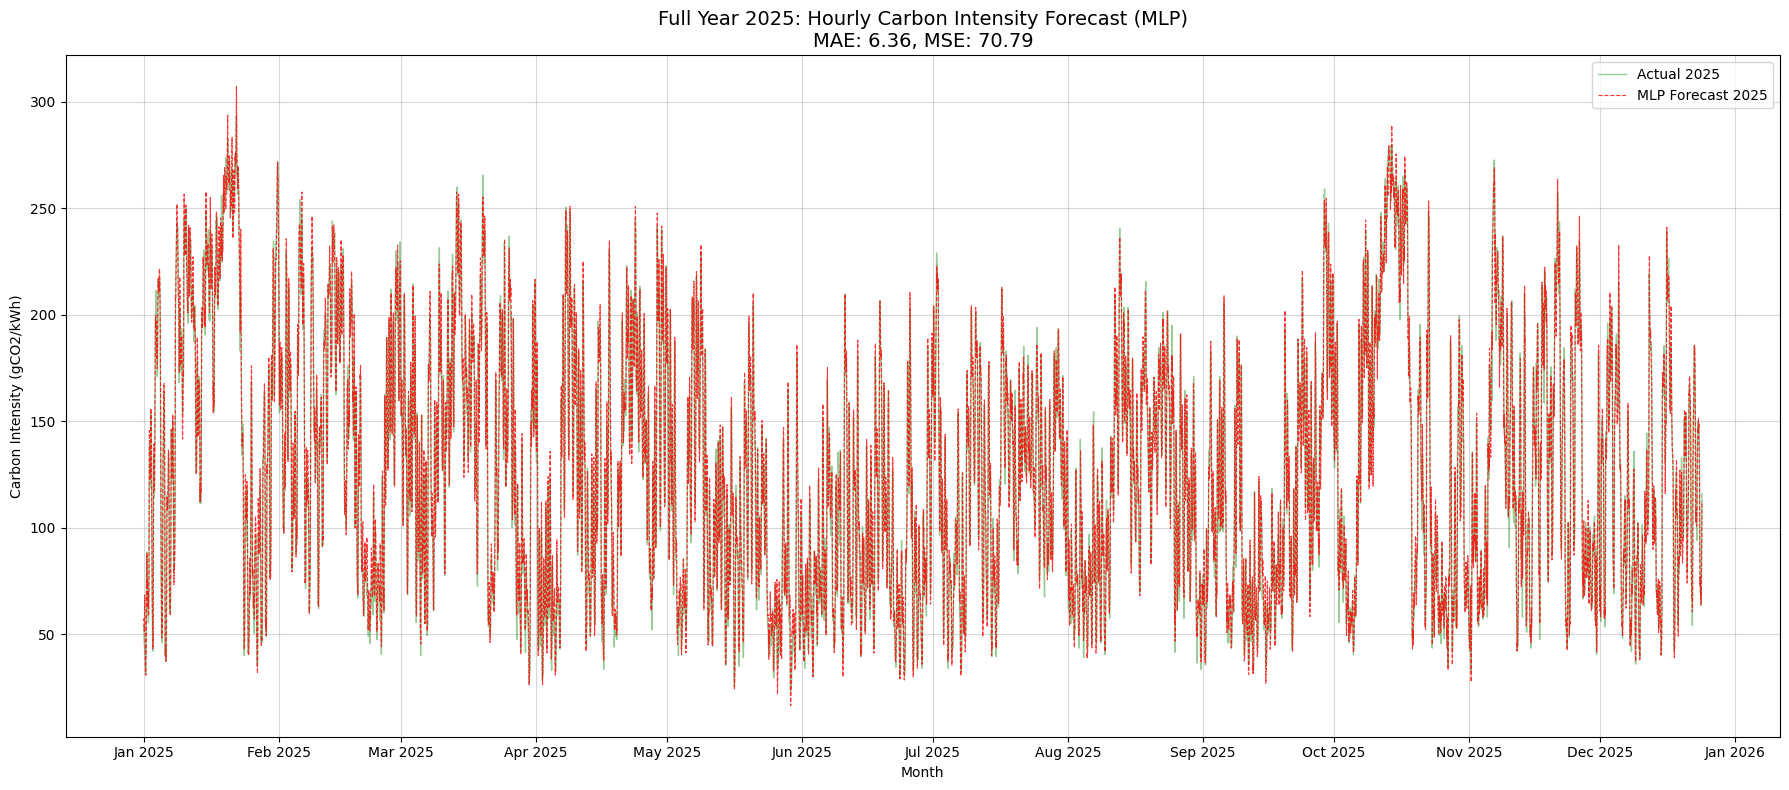

In [24]:
with PowerMonitor("Hourly_MLP_Forecasting.csv") as pm:
    start_time = time.time()
    val_pred_scaled = mlp.predict(X_val_scaled)
    val_pred = scaler_y.inverse_transform(val_pred_scaled.reshape(-1, 1)).flatten()

    test_pred_scaled = mlp.predict(X_test_scaled)
    test_pred = scaler_y.inverse_transform(test_pred_scaled.reshape(-1, 1)).flatten()

    val_mae = mean_absolute_error(y_val, val_pred)
    test_mae = mean_absolute_error(y_test, test_pred)
    test_mse = mean_squared_error(y_test, test_pred)

    print(f"Validation MAE: {val_mae:.2f}")
    print(f"Test MAE (2025): {test_mae:.2f}")
    print(f"Test MSE (2025): {test_mse:.2f}")

    plt.figure(figsize=(18, 8))
    plt.plot(test_data['DATETIME'], y_test, label='Actual 2025', color='green', alpha=0.4, linewidth=1)
    plt.plot(test_data['DATETIME'], test_pred, label='MLP Forecast 2025', color='red', alpha=0.8, linestyle='--', linewidth=0.8)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.title(f'Full Year 2025: Hourly Carbon Intensity Forecast (MLP)\nMAE: {test_mae:.2f}, MSE: {test_mse:.2f}', fontsize=14)
    plt.xlabel('Month')
    plt.ylabel('Carbon Intensity (gCO2/kWh)')
    plt.legend(loc='upper right')
    plt.grid(True, which='major', linestyle='-', alpha=0.5)
    plt.tight_layout()
    plt.show()
    execution_times['Forecasting'] = time.time() - start_time
power_stats['Forecasting'] = pm.stats()


In [25]:
# Print power usage summary
print("\nPOWER USAGE SUMMARY")
for task, stats in power_stats.items():
    print(f"{task}: {stats}")

# Calculate and print total energy used by the program
print("\n" + "="*50)
print("TOTAL ENERGY USED (Average Power × Runtime)")
print("="*50)

total_energy_joules = 0
for task, stats in power_stats.items():
    if stats and task in execution_times:
        # Sum up average power from all components (CPU Package, CPU Cores, CPU Memory, CPU Platform, GPU Power)
        total_avg_power = 0
        for component, data in stats.items():
            if isinstance(data, dict) and 'avg' in data:
                total_avg_power += data['avg']
        
        runtime = execution_times[task]
        energy = total_avg_power * runtime  # Energy in Joules = Power (Watts) × Time (seconds)
        total_energy_joules += energy
        print(f"{task}: {total_avg_power:.2f}W × {runtime:.4f}s = {energy:.2f}J")

print(f"\nTotal Energy Used: {total_energy_joules:.2f} Joules")
print(f"Total Energy Used: {total_energy_joules/1000:.4f} kJ (kilojoules)")
print("="*50)


POWER USAGE SUMMARY
Data Processing: {'CPU Package': {'min': 17.9111270904541, 'max': 17.9111270904541, 'avg': 17.9111270904541, 'samples': 1}, 'CPU Cores': {'min': 16.828716278076172, 'max': 16.828716278076172, 'avg': 16.828716278076172, 'samples': 1}, 'CPU Memory': {'min': 0.0, 'max': 0.0, 'avg': 0.0, 'samples': 1}, 'CPU Platform': {'min': 0.0, 'max': 0.0, 'avg': 0.0, 'samples': 1}, 'GPU Power': {'min': 0.03693021833896637, 'max': 0.03693021833896637, 'avg': 0.03693021833896637, 'samples': 1}}
Feature Engineering: None
Data Splitting: None
Scaling: None
Model Training: {'CPU Package': {'min': 7.880966663360596, 'max': 19.58492660522461, 'avg': 13.130964501429412, 'samples': 118}, 'CPU Cores': {'min': 4.485717296600342, 'max': 15.074965476989746, 'avg': 9.582189475075673, 'samples': 118}, 'CPU Memory': {'min': 0.0, 'max': 0.0, 'avg': 0.0, 'samples': 118}, 'CPU Platform': {'min': 0.0, 'max': 0.0, 'avg': 0.0, 'samples': 118}, 'GPU Power': {'min': 0.006784406024962664, 'max': 0.06434822